In [ ]:
from astropy.io import fits

I have put the data file in the same directory as I am running this notebook

In [ ]:
eventfile=fits.open('sw01088940000bevshsp_uf.evt.gz')

Now I extract the data, and some metadata, from the file

This is the 'header' metadata, which records some information about the data, when it was taken, by which telescope, and defined the columns and fields we will find in the data.
You don't have to look at all of these, but at least try to skim down to the 'ORIGIN' field

eventfile[1].header

Now we read in the real data!

In [ ]:
events=eventfile[1].data

This is a numpy array containing the gamma-ray photons, one for each row, which we call 'events'.

In [ ]:
events

What do the columns mean?

events.columns

How many are there?

len(events)

Over what timespan were they measured? by calling events['COLUMNNAME'] you can return a list corresponding to just that column of data

events['TIME'][-1]-events['TIME'][0]

Do you understand what I did inthe line above? What units is this measurement of time in?
Here's another way to know how long the observation was

eventfile[1].header['TELAPSE']

These are very slightly different values!

So now we can calcualte the average number of gamma-ray photons per second over the entire observation

len(events) / events['TIME'][-1]-events['TIME'][0]

now let's look at the data more closely, plotting it

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

What's the best way to visualize this data? There are many dimensions here...

We can try to construct a simple time series! 
But the timestamps are only 1 dimensional...and you need two dimensions for a useful plot. 
Remember, the timestamps are measuring the arrival times of individual photons, so let's make a histogram of these to plot the rate in a useful way

_=plt.hist(events['TIME'])

But this is very coarse, because we only have a few bins and thus each is ~100 seconds long. But we can already see some evidence for a burst! let's try more bins

_=plt.hist(events['TIME'],bins=500)

Wow look at that beautiful burst! Let's take a closer look at the time of interest

_=plt.hist(events['TIME'],bins=500)
plt.xlim(660920900,660921200)

But this data is really very big, and most of it seems uninteresting, so to save computational load, let's take only an interesting subset of it

In [ ]:
shortdat=events[(events['TIME']>660920900) & (events['TIME']<660921200)]

Convince yourself you understand what i just did ^^^

In [ ]:
shortdat

len(shortdat)

_=plt.hist(shortdat['TIME'],bins=1000)

**Excercise: Try to isolate only the time period during which the Gamma-Ray Burst (GRB) is visible above the background, and make a subset of data including only this time period.**

In [ ]:
shorterdat = events[(events['TIME']>660921026) & (events['TIME']<660921120)]

shorterdat

In [ ]:
_=plt.hist(shorterdat['TIME'],bins=1000)

What about the other dimensions of the data?

In [ ]:
_=plt.hist(shortdat['ENERGY'],bins=100)
plt.xlabel('Energy (keV)')

uhoh, some of our events have negative energy!!! 
Let's remove these from the data. We will also use the 'EVENT_FLAGS' column, which tells us if the data is good or not

In [ ]:
cleanevts = shortdat[(shortdat['EVENT_FLAGS']==0) & (shortdat['ENERGY']>15)]
cleanevts

In [ ]:
_=plt.hist(cleanevts['ENERGY'],bins=100)
plt.xlabel('Energy (keV)')

But this plot completely ignores the temporal information, can i visualize both at the same time?

In [ ]:
dur=40
bins=500
fig=plt.figure(figsize=(8,5))
etpix=plt.hist2d(cleanevts['TIME'], cleanevts['ENERGY'],bins=bins)
plt.xlabel('Time-T0 (s) ')
plt.ylabel('Energy (keV)')
plt.yscale('log')
plt.colorbar()
plt.title(f'{round(dur/bins,2)} s x {round(475/bins)} keV pixels')

Do you understand what is being shown in the plot above? If not, figure it out!

**Excercise: in words, describe the gamma-ray burst and relevant parameters, its structure and characteristics in time and energy. Try to think about how you might quantify some of these characteristics, like duration, spikiness, energy, etc, and if you can come up with a way of measuring them from the data.**

What about the other dimensions of the data, like DETX and DETY. What do these mean? How might they be useful?

In [ ]:
filterdat = shortdat[(shortdat['EVENT_FLAGS']==0) & (shortdat['ENERGY']>0)]
filterdat

In [ ]:
import numpy as np
import pandas as pd
array = np.empty((0,3), int)
index = -1
time = []

df = pd.DataFrame(filterdat, columns = ['TIME','DET_ID','EVENT_FLAGS','PHA','MASK_WEIGHT','DETX','DETY','PI','ENERGY'])

In [ ]:
df['TIME'] = df['TIME'].apply(lambda x: round(x))

In [ ]:
time.extend(df['TIME'].tolist())

In [ ]:
for i in time:
    if int(i) == 660920900:
        index = index + 1
        array = np.append(array, np.array([[int(df.iloc[index][5]), int(df.iloc[index][6]), int(df.iloc[index][8])]]), axis=0)

In [ ]:
df2 = pd.DataFrame(array, columns=['DETX', 'DETY', 'ENERGY'])
df2['DETX']

In [ ]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.widgets import Slider
#-------------------------------------------------------------------------------------
eventfile=fits.open('/home/jcode/Downloads/sw01088940000bevshsp_uf.evt.gz')
events=eventfile[1].data
shortdat=events[(events['TIME']>660920900) & (events['TIME']<660921200)]
filterdat = shortdat[(shortdat['EVENT_FLAGS']==0) & (shortdat['ENERGY']>0)]

#-------------------------------------------------------------------------------------
array = np.empty((0,3), int)
index = -1
time = []

df = pd.DataFrame(filterdat, columns = ['TIME','DET_ID','EVENT_FLAGS','PHA','MASK_WEIGHT','DETX','DETY','PI','ENERGY'])
df['TIME'] = df['TIME'].apply(lambda x: round(x))
time.extend(df['TIME'].tolist())

for i in time:
    if int(i) == 660920900:
        index = index + 1
        array = np.append(array, np.array([[int(df.iloc[index][5]), int(df.iloc[index][6]), int(df.iloc[index][8])]]), axis=0)

df2 = pd.DataFrame(array, columns=['DETX', 'DETY', 'ENERGY'])

#-------------------------------------------------------------------------------------
Xmax = 0
Ymax = 0

for i in df2['DETX']:
    if i > Xmax:
        Xmax = i
for i in df2['DETY']:
    if i > Ymax:
        Ymax = i
        
def round50(x, base=50):
    return base * round(x/base)
    
roundxlim = round50(Xmax, base=50) + 25
roundylim = round50(Ymax, base=50) + 25
        
#-------------------------------------------------------------------------------------      
init_x=df2['DETX']
init_y=df2['DETY']
init_energy=df2['ENERGY']

fig, ax = plt.subplots()
scat = ax.scatter(x=init_x, y=init_y, s=init_energy, alpha=0.5)

fig.subplots_adjust(bottom=0.25)

plt.xlim([-10, roundxlim])
plt.ylim([-10, roundylim])
plt.show()

In [ ]:
len(df2)

In [ ]:
Xmax = 0
Ymax = 0

for i in df2['DETX']:
    if i > Xmax:
        Xmax = i
for i in df2['DETY']:
    if i > Ymax:
        Ymax = i
        
def round50(x, base=50):
    print(base * round(x/base))
    
round50(Xmax, base=50)
round50(Ymax, base=50)

In [ ]:
import matplotlib.pyplot as plt
init_x=100
init_y=100
init_energy=10000

fig, ax = plt.subplots()
scat = ax.scatter(x=init_x, y=init_y, s=init_energy, alpha=0.5)

fig.subplots_adjust(bottom=0.25)

plt.show()

In [9]:
for i in time:
    if int(i) == 660920900:
        index = index + 1
        array = np.append(array, np.array([[int(df.iloc[index][5]), int(df.iloc[index][6]), int(df.iloc[index][8])]]), axis=0)
array    

array([[134, 156, 460],
       [177,  84,  38],
       [239,  59,  15],
       ...,
       [134,  79,  16],
       [137, 167,  21],
       [ 48,  83,  33]])

In [33]:
for i in range(len(time)):
    if int(time[i]) == 660920900:
        print(df.iloc[i][5])

134.0
177.0
239.0
259.0
248.0
224.0
255.0
22.0
119.0
188.0
216.0
102.0
242.0
24.0
202.0
19.0
8.0
183.0
245.0
114.0
101.0
90.0
281.0
175.0
48.0
57.0
2.0
252.0
134.0
281.0
254.0
42.0
239.0
261.0
101.0
21.0
137.0
4.0
74.0
90.0
12.0
23.0
72.0
154.0
48.0
280.0
282.0
248.0
186.0
274.0
276.0
81.0
139.0
31.0
154.0
110.0
258.0
19.0
63.0
25.0
74.0
3.0
243.0
278.0
99.0
225.0
255.0
112.0
175.0
204.0
65.0
230.0
132.0
135.0
7.0
31.0
33.0
131.0
31.0
36.0
80.0
186.0
248.0
40.0
156.0
235.0
258.0
101.0
76.0
123.0
219.0
14.0
55.0
239.0
284.0
241.0
19.0
105.0
112.0
271.0
54.0
62.0
99.0
140.0
180.0
174.0
139.0
234.0
248.0
20.0
54.0
254.0
285.0
36.0
219.0
135.0
117.0
229.0
222.0
216.0
248.0
189.0
252.0
49.0
277.0
68.0
111.0
111.0
192.0
230.0
204.0
23.0
230.0
111.0
11.0
98.0
265.0
221.0
49.0
239.0
246.0
226.0
212.0
7.0
64.0
94.0
92.0
133.0
132.0
246.0
116.0
12.0
45.0
260.0
32.0
50.0
95.0
194.0
8.0
258.0
169.0
42.0
29.0
132.0
248.0
79.0
98.0
41.0
254.0
270.0
168.0
60.0
81.0
265.0
147.0
4.0
8.0
246.0
119.0
170

In [34]:
index = -1
newxy = np.empty((0,2), int) #np.array([])
newsize = np.empty((0,1), int) #np.array([])
for i in range(len(time)):
    if int(time[i]) == 660920900:
        newxy = np.append(newxy, np.array([[int(df.iloc[i][5]), int(df.iloc[i][6])]]), axis=0)
        newsize = np.append(newsize, np.array([[int(df.iloc[i][8])]]), axis=0)

print(newxy)
print(newsize)

[[134 156]
 [177  84]
 [239  59]
 ...
 [162  44]
 [267   2]
 [ 20 126]]
[[460]
 [ 38]
 [ 15]
 ...
 [ 59]
 [ 44]
 [ 12]]


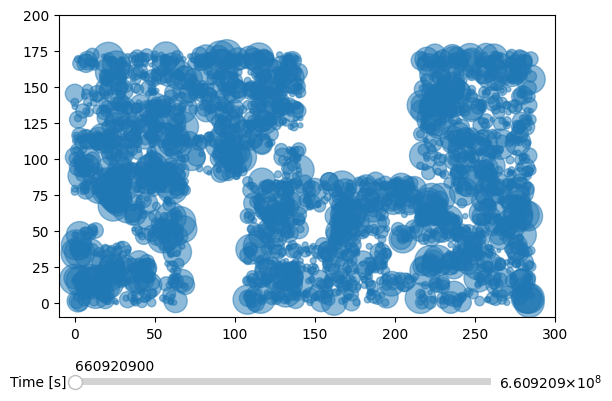

In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.widgets import Slider
#-------------------------------------------------------------------------------------
filename = '/home/jcode/Downloads/sw01088940000bevshsp_uf.evt.gz'
eventfile=fits.open(filename)
events=eventfile[1].data
shortdat=events[(events['TIME']>660920900) & (events['TIME']<660921200)]
filterdat = shortdat[(shortdat['EVENT_FLAGS']==0) & (shortdat['ENERGY']>0)]

#-------------------------------------------------------------------------------------
array = np.empty((0,3), int)
time = []

df = pd.DataFrame(filterdat, columns = ['TIME','DET_ID','EVENT_FLAGS','PHA','MASK_WEIGHT','DETX','DETY','PI','ENERGY'])
df['TIME'] = df['TIME'].apply(lambda x: round(x))
time.extend(df['TIME'].tolist())

for i in range(len(time)):
    if int(time[i]) == 660920900:
        array = np.append(array, np.array([[int(df.iloc[i][5]), int(df.iloc[i][6]), int(df.iloc[i][8])]]), axis=0)

df2 = pd.DataFrame(array, columns=['DETX', 'DETY', 'ENERGY'])

#-------------------------------------------------------------------------------------
Xmax = 0
Ymax = 0

for i in df2['DETX']:
    if i > Xmax:
        Xmax = i

for i in df2['DETY']:
    if i > Ymax:
        Ymax = i
        
def round50(x, base=50):
    return base * round(x/base)
    
Xmax = round50(Xmax, base=25) + 25
Ymax = round50(Ymax, base=25) + 25
        
#-------------------------------------------------------------------------------------
init_x=df2['DETX']
init_y=df2['DETY']
init_energy=df2['ENERGY']

fig, ax = plt.subplots()
scat = ax.scatter(x=init_x, y=init_y, s=init_energy, alpha=0.5)
plt.xlim([-10, Xmax])
plt.ylim([-10, Ymax])

fig.subplots_adjust(bottom=0.25)

#The horizontal slider for time
axtime = fig.add_axes([0.15, 0.1, 0.65, 0.03])
time_slider = Slider(
    ax=axtime,
    label='Time [s]',
    valmin=int(time[0]),
    valmax=int(time[-1]),
    valinit=660920900, valstep=1,
)
    
# The function to be called anytime a slider's value changes
def update(val):
    newx = np.empty((0,1), int)
    newy = np.empty((0,1), int)
    newsize = np.empty((0,1), int)
    for i in range(len(time)):
        if int(time[i]) == time_slider.val:
            newx = np.append(newx, np.array([[int(df.iloc[i][5])]]), axis=0)
            newy = np.append(newy, np.array([[int(df.iloc[i][6])]]), axis=0)
            newsize = np.append(newsize, np.array([[int(df.iloc[i][8])]]), axis=0)
    ax.clear()
    scat = ax.scatter(x=newx, y=newy, s=newsize, alpha=0.5)
    fig.canvas.draw_idle()


# register the update function with each slider
time_slider.on_changed(update)


plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.widgets import Slider

